In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.8 MB/s eta 0:00:00


In [ ]:
# 📁 Upload CSVs manually
from google.colab import files
import pandas as pd
from pulp import *

# Upload your 3 files interactively
uploaded = files.upload()

# Read the uploaded CSVs
warehouse_df = pd.read_csv("updatedwarehouse_info.csv")
demand_df = pd.read_csv("demand_table.csv").dropna(axis=1, how='all')
cost_matrix = pd.read_csv("updatedTransportCostMatrix.csv", index_col=0)

# 🧮 Setup
warehouses = warehouse_df["Warehouse"].tolist()
demand_zones = demand_df["Demand Zone"].tolist()

cost = {(w, d): cost_matrix.loc[w, d] for w in warehouses for d in demand_zones}
demand = dict(zip(demand_df["Demand Zone"], demand_df["Estimated Monthly Orders"]))
# Strip all column names to avoid hidden spaces
warehouse_df.columns = warehouse_df.columns.str.strip()

# Now access safely
capacity = dict(zip(warehouse_df["Warehouse"], warehouse_df["Capacity (units)"]))

running_cost = dict(zip(warehouse_df["Warehouse"], warehouse_df["Monthly Running Cost (₹)"]))

# 🧠 Build Model
model = LpProblem("Goa_Warehouse_Optimization", LpMinimize)
x = LpVariable.dicts("OpenWarehouse", warehouses, cat=LpBinary)
y = LpVariable.dicts("Ship", [(w, d) for w in warehouses for d in demand_zones], lowBound=0)

# 💰 Objective
model += (
    lpSum(x[w] * running_cost[w] for w in warehouses) +
    lpSum(y[w, d] * cost[w, d] for w in warehouses for d in demand_zones)
)

# ✅ Constraints
for d in demand_zones:
    model += lpSum(y[w, d] for w in warehouses) == demand[d]

for w in warehouses:
    model += lpSum(y[w, d] for d in demand_zones) <= capacity[w] * x[w]

# 🚀 Solve
model.solve()

# 📊 Output
print("📍 Status:", LpStatus[model.status])
print("\n🏬 Warehouses Opened:")
for w in warehouses:
    if x[w].varValue == 1:
        print(f"  ✅ {w}")

print("\n💰 Total Monthly Cost (Z): ₹", round(value(model.objective), 2))

Saving demand_table.csv to demand_table.csv
Saving updatedwarehouse_info.csv to updatedwarehouse_info.csv
Saving updatedTransportCostMatrix.csv to updatedTransportCostMatrix.csv
📍 Status: Optimal

🏬 Warehouses Opened:
  ✅ Porvorim
  ✅ Verna
  ✅ Ponda
  ✅ Margao
  ✅ Mapusa

💰 Total Monthly Cost (Z): ₹ 2316105.05


In [ ]:
import pandas as pd

# 🔍 Breakdown per warehouse
warehouse_breakdown = []

for w in warehouses:
    if x[w].varValue == 1:
        # Fixed cost (rent + staff)
        fixed = running_cost[w]

        # Total parcels shipped
        shipped = sum(y[w, d].varValue for d in demand_zones if y[w, d].varValue > 0)

        # Total transport cost from this warehouse
        transport_cost = sum(y[w, d].varValue * cost[w, d] for d in demand_zones if y[w, d].varValue > 0)

        # Append breakdown
        warehouse_breakdown.append({
            "Warehouse": w,
            "Units Shipped": int(shipped),
            "Monthly Rent + Staff (₹)": round(fixed, 2),
            "Transport Cost (₹)": round(transport_cost, 2),
            "Total Cost (₹)": round(fixed + transport_cost, 2)
        })

# Show as DataFrame
pd.DataFrame(warehouse_breakdown)

,Warehouse,Units Shipped,Monthly Rent + Staff (₹),Transport Cost (₹),Total Cost (₹)
0,Porvorim,24000,297000,105627.08,402627.08
1,Verna,36683,267000,331538.95,598538.95
2,Ponda,30000,237000,118343.12,355343.12
3,Margao,36000,267000,268221.14,535221.14
4,Mapusa,28000,277000,147374.76,424374.76


In [ ]:
import pandas as pd

# Build cost breakdown again from existing results
warehouse_breakdown = []
total_units_all = 0

for w in warehouses:
    if x[w].varValue == 1:
        fixed = running_cost[w]
        shipped = sum(y[w, d].varValue for d in demand_zones if y[w, d].varValue > 0)
        transport = sum(y[w, d].varValue * cost[w, d] for d in demand_zones if y[w, d].varValue > 0)

        total_units_all += shipped

        warehouse_breakdown.append({
            "Warehouse": w,
            "Units Shipped": int(shipped),
            "Monthly Rent + Staff (₹)": round(fixed, 2),
            "Transport Cost (₹)": round(transport, 2),
            "Total Cost (₹)": round(fixed + transport, 2),
        })

# Add extra metrics
for w in warehouse_breakdown:
    w["Avg Cost per Parcel (₹)"] = round(w["Total Cost (₹)"] / w["Units Shipped"], 2)
    w["% of Total Demand Handled"] = round((w["Units Shipped"] / total_units_all) * 100, 2)

# Show final result
pd.DataFrame(warehouse_breakdown)

,Warehouse,Units Shipped,Monthly Rent + Staff (₹),Transport Cost (₹),Total Cost (₹),Avg Cost per Parcel (₹),% of Total Demand Handled
0,Porvorim,24000,297000,105627.08,402627.08,16.78,15.52
1,Verna,36683,267000,331538.95,598538.95,16.32,23.71
2,Ponda,30000,237000,118343.12,355343.12,11.84,19.39
3,Margao,36000,267000,268221.14,535221.14,14.87,23.27
4,Mapusa,28000,277000,147374.76,424374.76,15.16,18.10


In [ ]:
# 📁 Upload CSVs manually
from google.colab import files
import pandas as pd
from pulp import *

# Upload your 3 files
uploaded = files.upload()

# Read the uploaded CSVs
warehouse_df = pd.read_csv("updatedwarehouse_info.csv")
demand_df = pd.read_csv("demand_table.csv").dropna(axis=1, how='all')
cost_matrix = pd.read_csv("updatedTransportCostMatrix.csv", index_col=0)

# 🧮 Setup
warehouse_df.columns = warehouse_df.columns.str.strip()  # Clean column names
warehouses = warehouse_df["Warehouse"].tolist()
demand_zones = demand_df["Demand Zone"].tolist()

cost = {(w, d): cost_matrix.loc[w, d] for w in warehouses for d in demand_zones}
demand = dict(zip(demand_df["Demand Zone"], demand_df["Estimated Monthly Orders"]))
capacity = dict(zip(warehouse_df["Warehouse"], warehouse_df["Capacity (units)"]))
running_cost = dict(zip(warehouse_df["Warehouse"], warehouse_df["Monthly Running Cost (₹)"]))

# 🧠 Build Model
model = LpProblem("Goa_Warehouse_Optimization", LpMinimize)
x = LpVariable.dicts("OpenWarehouse", warehouses, cat=LpBinary)
y = LpVariable.dicts("Ship", [(w, d) for w in warehouses for d in demand_zones], lowBound=0)

# 💰 Objective
model += (
    lpSum(x[w] * running_cost[w] for w in warehouses) +
    lpSum(y[w, d] * cost[w, d] for w in warehouses for d in demand_zones)
)

# ✅ Constraints
for d in demand_zones:
    model += lpSum(y[w, d] for w in warehouses) == demand[d]

for w in warehouses:
    model += lpSum(y[w, d] for d in demand_zones) <= capacity[w] * x[w]

# 🔁 Scenario Constraint: Limit to max X warehouses
max_warehouses = 6  # Change this to 4, 5, 7, or 8
model += lpSum(x[w] for w in warehouses) <= max_warehouses, "Max_Warehouse_Limit"

# 🚀 Solve
model.solve()

# 📊 Output
print("📍 Status:", LpStatus[model.status])
print("\n🏬 Warehouses Opened:")
for w in warehouses:
    if x[w].varValue == 1:
        print(f"  ✅ {w}")

print("\n💰 Total Monthly Cost (Z): ₹", round(value(model.objective), 2))



ModuleNotFoundError: No module named 'pulp'

In [ ]:
# 📁 Upload CSVs manually
from google.colab import files
import pandas as pd
from pulp import *

# Upload your 3 files
uploaded = files.upload()

# Read the uploaded CSVs
warehouse_df = pd.read_csv("updatedwarehouse_info.csv")
demand_df = pd.read_csv("demand_table.csv").dropna(axis=1, how='all')
cost_matrix = pd.read_csv("updatedTransportCostMatrix.csv", index_col=0)

# 🧮 Setup
warehouse_df.columns = warehouse_df.columns.str.strip()  # Clean column names
warehouses = warehouse_df["Warehouse"].tolist()
demand_zones = demand_df["Demand Zone"].tolist()

cost = {(w, d): cost_matrix.loc[w, d] for w in warehouses for d in demand_zones}
demand = dict(zip(demand_df["Demand Zone"], demand_df["Estimated Monthly Orders"]))
capacity = dict(zip(warehouse_df["Warehouse"], warehouse_df["Capacity (units)"]))
running_cost = dict(zip(warehouse_df["Warehouse"], warehouse_df["Monthly Running Cost (₹)"]))

# 🧠 Build Model
model = LpProblem("Goa_Warehouse_Optimization", LpMinimize)
x = LpVariable.dicts("OpenWarehouse", warehouses, cat=LpBinary)
y = LpVariable.dicts("Ship", [(w, d) for w in warehouses for d in demand_zones], lowBound=0)

# 💰 Objective
model += (
    lpSum(x[w] * running_cost[w] for w in warehouses) +
    lpSum(y[w, d] * cost[w, d] for w in warehouses for d in demand_zones)
)

# ✅ Constraints
for d in demand_zones:
    model += lpSum(y[w, d] for w in warehouses) == demand[d]

for w in warehouses:
    model += lpSum(y[w, d] for d in demand_zones) <= capacity[w] * x[w]

# 🔁 Scenario Constraint: Limit to max X warehouses
max_warehouses = 4  # Change this to 4, 5, 7, or 8
model += lpSum(x[w] for w in warehouses) <= max_warehouses, "Max_Warehouse_Limit"

# 🚀 Solve
model.solve()

# 📊 Output
print("📍 Status:", LpStatus[model.status])
print("\n🏬 Warehouses Opened:")
for w in warehouses:
    if x[w].varValue == 1:
        print(f"  ✅ {w}")

print("\n💰 Total Monthly Cost (Z): ₹", round(value(model.objective), 2))

Saving demand_table.csv to demand_table (1).csv
Saving updatedwarehouse_info.csv to updatedwarehouse_info (1).csv
Saving updatedTransportCostMatrix.csv to updatedTransportCostMatrix (1).csv
📍 Status: Optimal

🏬 Warehouses Opened:
  ✅ Verna
  ✅ Vasco
  ✅ Margao
  ✅ Mapusa

💰 Total Monthly Cost (Z): ₹ 2317950.91


In [ ]:
# 📁 Upload CSVs manually
from google.colab import files
import pandas as pd
from pulp import *

# Upload your 3 files
uploaded = files.upload()

# Read the uploaded CSVs
warehouse_df = pd.read_csv("updatedwarehouse_info.csv")
demand_df = pd.read_csv("demand_table.csv").dropna(axis=1, how='all')
cost_matrix = pd.read_csv("updatedTransportCostMatrix.csv", index_col=0)

# 🧮 Setup
warehouse_df.columns = warehouse_df.columns.str.strip()  # Clean column names
warehouses = warehouse_df["Warehouse"].tolist()
demand_zones = demand_df["Demand Zone"].tolist()

cost = {(w, d): cost_matrix.loc[w, d] for w in warehouses for d in demand_zones}
demand = dict(zip(demand_df["Demand Zone"], demand_df["Estimated Monthly Orders"]))
capacity = dict(zip(warehouse_df["Warehouse"], warehouse_df["Capacity (units)"]))
running_cost = dict(zip(warehouse_df["Warehouse"], warehouse_df["Monthly Running Cost (₹)"]))

# 🧠 Build Model
model = LpProblem("Goa_Warehouse_Optimization", LpMinimize)
x = LpVariable.dicts("OpenWarehouse", warehouses, cat=LpBinary)
y = LpVariable.dicts("Ship", [(w, d) for w in warehouses for d in demand_zones], lowBound=0)

# 💰 Objective
model += (
    lpSum(x[w] * running_cost[w] for w in warehouses) +
    lpSum(y[w, d] * cost[w, d] for w in warehouses for d in demand_zones)
)

# ✅ Constraints
for d in demand_zones:
    model += lpSum(y[w, d] for w in warehouses) == demand[d]

for w in warehouses:
    model += lpSum(y[w, d] for d in demand_zones) <= capacity[w] * x[w]

# 🔁 Scenario Constraint: Limit to max X warehouses
max_warehouses = 3  # Change this to 4, 5, 7, or 8
model += lpSum(x[w] for w in warehouses) <= max_warehouses, "Max_Warehouse_Limit"

# 🚀 Solve
model.solve()

# 📊 Output
print("📍 Status:", LpStatus[model.status])
print("\n🏬 Warehouses Opened:")
for w in warehouses:
    if x[w].varValue == 1:
        print(f"  ✅ {w}")

print("\n💰 Total Monthly Cost (Z): ₹", round(value(model.objective), 2))

Saving demand_table.csv to demand_table (1).csv
Saving updatedwarehouse_info.csv to updatedwarehouse_info (1).csv
Saving updatedTransportCostMatrix.csv to updatedTransportCostMatrix (1).csv
📍 Status: Infeasible

🏬 Warehouses Opened:
  ✅ Verna
  ✅ Vasco
  ✅ Margao

💰 Total Monthly Cost (Z): ₹ 4988189.7


In [ ]:
# 📁 Upload CSVs manually
from google.colab import files
import pandas as pd
from pulp import *

# Upload your 3 files
uploaded = files.upload()

# Read the uploaded CSVs
warehouse_df = pd.read_csv("updatedwarehouse_info.csv")
demand_df = pd.read_csv("demand_table.csv").dropna(axis=1, how='all')
cost_matrix = pd.read_csv("updatedTransportCostMatrix.csv", index_col=0)

# 🧮 Setup
warehouse_df.columns = warehouse_df.columns.str.strip()  # Clean column names
warehouses = warehouse_df["Warehouse"].tolist()
demand_zones = demand_df["Demand Zone"].tolist()

cost = {(w, d): cost_matrix.loc[w, d] for w in warehouses for d in demand_zones}
demand = dict(zip(demand_df["Demand Zone"], demand_df["Estimated Monthly Orders"]))
capacity = dict(zip(warehouse_df["Warehouse"], warehouse_df["Capacity (units)"]))
running_cost = dict(zip(warehouse_df["Warehouse"], warehouse_df["Monthly Running Cost (₹)"]))

# 🧠 Build Model
model = LpProblem("Goa_Warehouse_Optimization", LpMinimize)
x = LpVariable.dicts("OpenWarehouse", warehouses, cat=LpBinary)
y = LpVariable.dicts("Ship", [(w, d) for w in warehouses for d in demand_zones], lowBound=0)

# 💰 Objective
model += (
    lpSum(x[w] * running_cost[w] for w in warehouses) +
    lpSum(y[w, d] * cost[w, d] for w in warehouses for d in demand_zones)
)

# ✅ Constraints
for d in demand_zones:
    model += lpSum(y[w, d] for w in warehouses) == demand[d]

for w in warehouses:
    model += lpSum(y[w, d] for d in demand_zones) <= capacity[w] * x[w]

# 🔁 Scenario Constraint: Limit to max X warehouses
max_warehouses = 8  # Change this to 4, 5, 7, or 8
model += lpSum(x[w] for w in warehouses) <= max_warehouses, "Max_Warehouse_Limit"

# 🚀 Solve
model.solve()

# 📊 Output
print("📍 Status:", LpStatus[model.status])
print("\n🏬 Warehouses Opened:")
for w in warehouses:
    if x[w].varValue == 1:
        print(f"  ✅ {w}")

print("\n💰 Total Monthly Cost (Z): ₹", round(value(model.objective), 2))

Saving demand_table.csv to demand_table (2).csv
Saving updatedwarehouse_info.csv to updatedwarehouse_info (2).csv
Saving updatedTransportCostMatrix.csv to updatedTransportCostMatrix (2).csv
📍 Status: Optimal

🏬 Warehouses Opened:
  ✅ Porvorim
  ✅ Verna
  ✅ Ponda
  ✅ Margao
  ✅ Mapusa

💰 Total Monthly Cost (Z): ₹ 2316105.05


In [ ]:
# 📁 Upload CSVs manually
from google.colab import files
import pandas as pd
from pulp import *

# Upload your 3 files
uploaded = files.upload()

# Read the uploaded CSVs
warehouse_df = pd.read_csv("updatedwarehouse_info.csv")
demand_df = pd.read_csv("demand_table.csv").dropna(axis=1, how='all')
cost_matrix = pd.read_csv("updatedTransportCostMatrix.csv", index_col=0)

# 🧮 Setup
warehouse_df.columns = warehouse_df.columns.str.strip()  # Clean column names
warehouses = warehouse_df["Warehouse"].tolist()
demand_zones = demand_df["Demand Zone"].tolist()

cost = {(w, d): cost_matrix.loc[w, d] for w in warehouses for d in demand_zones}
demand = dict(zip(demand_df["Demand Zone"], demand_df["Estimated Monthly Orders"]))
capacity = dict(zip(warehouse_df["Warehouse"], warehouse_df["Capacity (units)"]))
running_cost = dict(zip(warehouse_df["Warehouse"], warehouse_df["Monthly Running Cost (₹)"]))

# 🧠 Build Model
model = LpProblem("Goa_Warehouse_Optimization", LpMinimize)
x = LpVariable.dicts("OpenWarehouse", warehouses, cat=LpBinary)
y = LpVariable.dicts("Ship", [(w, d) for w in warehouses for d in demand_zones], lowBound=0)

# 💰 Objective
model += (
    lpSum(x[w] * running_cost[w] for w in warehouses) +
    lpSum(y[w, d] * cost[w, d] for w in warehouses for d in demand_zones)
)

# ✅ Constraints
for d in demand_zones:
    model += lpSum(y[w, d] for w in warehouses) == demand[d]

for w in warehouses:
    model += lpSum(y[w, d] for d in demand_zones) <= capacity[w] * x[w]

# 🔁 Scenario Constraint: Limit to max X warehouses
max_warehouses = 6  # Change this to 4, 5, 7, or 8
model += lpSum(x[w] for w in warehouses) <= max_warehouses, "Max_Warehouse_Limit"

# 🚀 Solve
model.solve()

# 📊 Output
print("📍 Status:", LpStatus[model.status])
print("\n🏬 Warehouses Opened:")
for w in warehouses:
    if x[w].varValue == 1:
        print(f"  ✅ {w}")

print("\n💰 Total Monthly Cost (Z): ₹", round(value(model.objective), 2))

Saving demand_table.csv to demand_table (1).csv
Saving updatedwarehouse_info.csv to updatedwarehouse_info (1).csv
Saving updatedTransportCostMatrix.csv to updatedTransportCostMatrix (1).csv
📍 Status: Optimal

🏬 Warehouses Opened:
  ✅ Porvorim
  ✅ Verna
  ✅ Ponda
  ✅ Margao
  ✅ Mapusa

💰 Total Monthly Cost (Z): ₹ 2316105.05


In [ ]:
# 📁 Upload CSVs manually
from google.colab import files
import pandas as pd
from pulp import *

# Upload your 3 files
uploaded = files.upload()

# Read the uploaded CSVs
warehouse_df = pd.read_csv("updatedwarehouse_info.csv")
demand_df = pd.read_csv("demand_table.csv").dropna(axis=1, how='all')
cost_matrix = pd.read_csv("updatedTransportCostMatrix.csv", index_col=0)

# 🧮 Setup
warehouse_df.columns = warehouse_df.columns.str.strip()  # Clean column names
warehouses = warehouse_df["Warehouse"].tolist()
demand_zones = demand_df["Demand Zone"].tolist()

cost = {(w, d): cost_matrix.loc[w, d] for w in warehouses for d in demand_zones}
demand = dict(zip(demand_df["Demand Zone"], demand_df["Estimated Monthly Orders"]))
capacity = dict(zip(warehouse_df["Warehouse"], warehouse_df["Capacity (units)"]))
running_cost = dict(zip(warehouse_df["Warehouse"], warehouse_df["Monthly Running Cost (₹)"]))

# 🧠 Build Model
model = LpProblem("Goa_Warehouse_Optimization", LpMinimize)
x = LpVariable.dicts("OpenWarehouse", warehouses, cat=LpBinary)
y = LpVariable.dicts("Ship", [(w, d) for w in warehouses for d in demand_zones], lowBound=0)

# 💰 Objective
model += (
    lpSum(x[w] * running_cost[w] for w in warehouses) +
    lpSum(y[w, d] * cost[w, d] for w in warehouses for d in demand_zones)
)

# ✅ Constraints
for d in demand_zones:
    model += lpSum(y[w, d] for w in warehouses) == demand[d]

for w in warehouses:
    model += lpSum(y[w, d] for d in demand_zones) <= capacity[w] * x[w]

# 🔁 Scenario Constraint: Limit to max X warehouses
max_warehouses = 1  # Change this to 4, 5, 7, or 8
model += lpSum(x[w] for w in warehouses) <= max_warehouses, "Max_Warehouse_Limit"

# 🚀 Solve
model.solve()

# 📊 Output
print("📍 Status:", LpStatus[model.status])
print("\n🏬 Warehouses Opened:")
for w in warehouses:
    if x[w].varValue == 1:
        print(f"  ✅ {w}")

print("\n💰 Total Monthly Cost (Z): ₹", round(value(model.objective), 2))

ModuleNotFoundError: No module named 'pulp'

In [ ]:
import pandas as pd

# Load your data
warehouse_df = pd.read_csv("updatedwarehouse_info.csv")
demand_df = pd.read_csv("demand_table.csv")
cost_matrix = pd.read_csv("updatedTransportCostMatrix.csv", index_col=0)

# 📊 Table B.1: Warehouse Info
print("📘 Table B.1: Warehouse Information Table (Head)")
print("📌 Columns:", list(warehouse_df.columns))
print(warehouse_df.head())

# 📊 Table B.2: Demand Table
print("\n📘 Table B.2: Demand Table (Head)")
print("📌 Columns:", list(demand_df.columns))
print(demand_df.head())

# 📊 Table B.3: Transport Cost Matrix Sample
print("\n📘 Table B.3: Transport Cost Matrix (Sample)")
print("📌 Row = 'Porvorim'")
print("📌 Columns:", list(cost_matrix.columns[:5]))
print(cost_matrix.loc["Porvorim"].head(5))


📘 Table B.1: Warehouse Information Table (Head)
📌 Columns: ['Warehouse', 'Capacity (units)', 'Monthly Running Cost (₹)']
   Warehouse  Capacity (units)  Monthly Running Cost (₹)
0     Panjim             20000                    547000
1   Porvorim             24000                    297000
2      Verna             50000                    267000
3  Goa Velha             16000                    227000
4      Vasco             46000                    307000

📘 Table B.2: Demand Table (Head)
📌 Columns: ['Demand Zone', 'Estimated Monthly Orders', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']
     Demand Zone  Estimated Monthly Orders  Unnamed: 2  Unnamed: 3  \
0         Panaji                     12000         NaN         NaN   
1         Margao                      8500         NaN         NaN   
2         Mapusa                     10500         NaN         NaN   
3  Vasco Da Gama                      7000         NaN         NaN   
4       Porvorim            

In [ ]:
import pandas as pd

# Load the transport cost matrix
cost_matrix = pd.read_csv("updatedTransportCostMatrix.csv", index_col=0)

# Display the full table
cost_matrix


,Mandrem,Pernem (SC),Bicholim,Tivim,Mapusa,Siolim,Saligao,Calangute,Porvorim,Aldona,...,Margao,Benaulim,Navelim,Cuncolim,Velim,Quepem,Curchorem,Sanvordem,Sanguem,Canacona
Panjim,27.04,21.41,13.52,29.29,9.58,16.90,27.04,15.77,18.03,11.27,...,20.28,28.73,20.84,14.08,13.52,31.55,29.86,6.76,25.91,9.01
Porvorim,15.60,9.36,24.96,14.04,6.76,17.68,11.96,30.68,0.00,9.36,...,19.76,14.04,18.20,27.56,22.36,9.88,23.40,11.96,20.80,29.64
Verna,10.40,7.37,9.97,13.87,21.23,13.00,10.83,23.40,11.70,24.27,...,19.07,19.07,18.20,6.07,22.10,20.80,21.67,16.03,6.93,7.80
Goa Velha,10.31,12.74,26.09,25.48,34.58,19.41,20.02,27.91,26.69,32.15,...,30.94,13.35,24.87,29.12,35.19,24.87,7.89,23.66,27.91,19.41
Vasco,22.88,25.74,11.44,24.79,18.11,21.45,10.49,19.54,7.63,14.78,...,5.72,22.88,7.15,8.10,17.16,8.58,21.93,20.02,24.31,25.26
Ponda,14.30,10.40,17.77,17.77,14.30,21.67,25.13,25.13,9.10,20.80,...,17.77,6.50,17.77,5.63,8.67,11.27,20.37,14.30,6.07,18.63
Margao,6.50,13.43,8.67,24.70,10.83,18.20,7.80,6.50,10.83,16.47,...,0.00,25.57,13.87,17.33,16.90,22.10,19.07,6.93,10.83,15.17
Mapusa,29.64,30.16,5.72,5.20,0.00,29.64,10.92,7.28,23.92,21.32,...,17.68,22.88,17.68,19.76,14.04,28.60,14.04,5.72,22.88,13.00


from matplotlib import pyplot as plt
cost_matrix['Mandrem'].plot(kind='hist', bins=20, title='Mandrem')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cost_matrix['Pernem (SC)'].plot(kind='hist', bins=20, title='Pernem (SC)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cost_matrix['Bicholim'].plot(kind='hist', bins=20, title='Bicholim')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cost_matrix['Tivim'].plot(kind='hist', bins=20, title='Tivim')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cost_matrix.plot(kind='scatter', x='Mandrem', y='Pernem (SC)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cost_matrix.plot(kind='scatter', x='Pernem (SC)', y='Bicholim', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cost_matrix.plot(kind='scatter', x='Bicholim', y='Tivim', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cost_matrix.plot(kind='scatter', x='Tivim', y='Mapusa', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cost_matrix['Mandrem'].plot(kind='line', figsize=(8, 4), title='Mandrem')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
cost_matrix['Pernem (SC)'].plot(kind='line', figsize=(8, 4), title='Pernem (SC)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
cost_matrix['Bicholim'].plot(kind='line', figsize=(8, 4), title='Bicholim')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
cost_matrix['Tivim'].plot(kind='line', figsize=(8, 4), title='Tivim')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Load the demand matrix
demand = pd.read_csv("updatedwarehouse_info.csv", index_col=0)

# Display the full table
demand

,Capacity (units),Monthly Running Cost (₹)
Warehouse,,
Panjim,20000,547000
Porvorim,24000,297000
Verna,50000,267000
Goa Velha,16000,227000
Vasco,46000,307000
Ponda,30000,237000
Margao,36000,267000
Mapusa,28000,277000


from matplotlib import pyplot as plt
demand['Capacity (units)'].plot(kind='hist', bins=20, title='Capacity (units)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
demand['Monthly Running Cost (₹)'].plot(kind='hist', bins=20, title='Monthly Running Cost (₹)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
demand.plot(kind='scatter', x='Capacity (units)', y='Monthly Running Cost (₹)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
demand['Capacity (units)'].plot(kind='line', figsize=(8, 4), title='Capacity (units)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
demand['Monthly Running Cost (₹)'].plot(kind='line', figsize=(8, 4), title='Monthly Running Cost (₹)')
plt.gca().spines[['top', 'right']].set_visible(False)

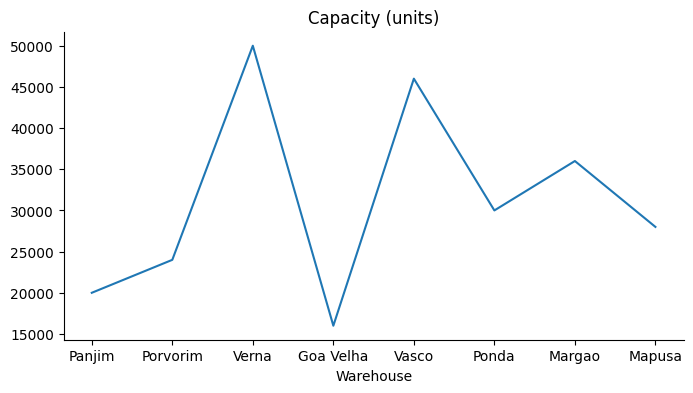

In [ ]:
from matplotlib import pyplot as plt
demand['Capacity (units)'].plot(kind='line', figsize=(8, 4), title='Capacity (units)')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Load the demand matrix
ware = pd.read_csv("demand_table.csv", index_col=0)

# Display the full table
ware

,Estimated Monthly Orders,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
Demand Zone,,,,,,
Panaji,12000,NaN,NaN,NaN,NaN,NaN
Margao,8500,NaN,NaN,NaN,NaN,NaN
Mapusa,10500,NaN,NaN,NaN,NaN,NaN
Vasco Da Gama,7000,NaN,NaN,NaN,NaN,NaN
Porvorim,9500,NaN,NaN,NaN,NaN,NaN
Ponda,8000,NaN,NaN,NaN,NaN,NaN
Bicholim,6500,NaN,NaN,NaN,NaN,NaN
Curchorem,5800,NaN,NaN,NaN,NaN,NaN
Canacona,3200,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 🧹 Clean the DataFrame by removing columns that are completely empty or unnamed
demand_df = pd.read_csv("demand_table.csv")

# Drop any columns that are completely empty (NaN) or start with "Unnamed"
demand_df = demand_df.loc[:, ~demand_df.columns.str.contains('^Unnamed')]
demand_df = demand_df.dropna(axis=1, how='all')  # Optional, ensures no fully empty columns remain

# Preview the cleaned data
demand_df


,Demand Zone,Estimated Monthly Orders
0,Panaji,12000
1,Margao,8500
2,Mapusa,10500
3,Vasco Da Gama,7000
4,Porvorim,9500
5,Ponda,8000
6,Bicholim,6500
7,Curchorem,5800
8,Canacona,3200
9,Sanguem,2800


from matplotlib import pyplot as plt
demand_df['Estimated Monthly Orders'].plot(kind='hist', bins=20, title='Estimated Monthly Orders')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
demand_df['Estimated Monthly Orders'].plot(kind='line', figsize=(8, 4), title='Estimated Monthly Orders')
plt.gca().spines[['top', 'right']].set_visible(False)

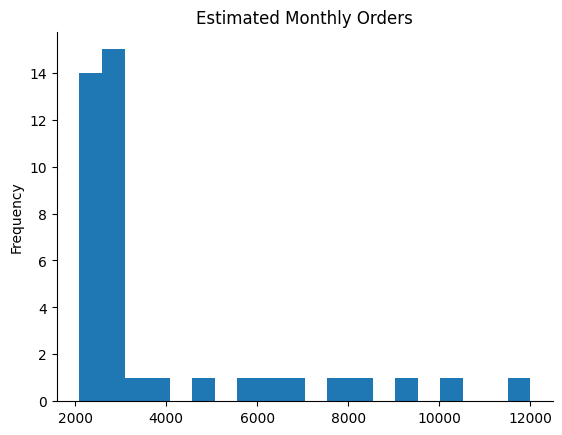

In [ ]:
from matplotlib import pyplot as plt
demand_df['Estimated Monthly Orders'].plot(kind='hist', bins=20, title='Estimated Monthly Orders')
plt.gca().spines[['top', 'right',]].set_visible(False)

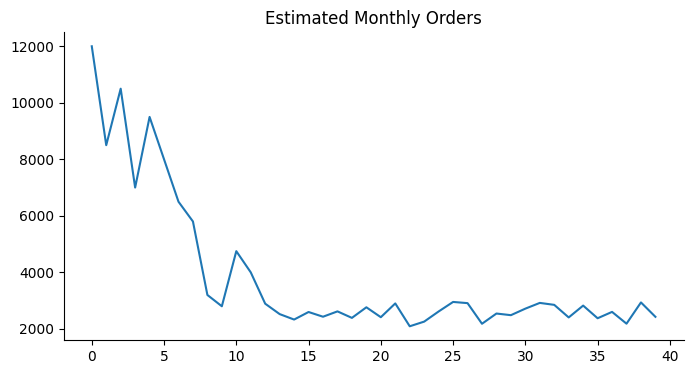

In [ ]:
from matplotlib import pyplot as plt
demand_df['Estimated Monthly Orders'].plot(kind='line', figsize=(8, 4), title='Estimated Monthly Orders')
plt.gca().spines[['top', 'right']].set_visible(False)